In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nengo
import pandas as pd
import time
import pickle
from pathlib import Path
import re
from model_1p7 import *
palette = sns.color_palette('tab10')
sns.set_palette(palette)
sns.set(context='notebook', style='whitegrid', rc={"font.family": "DejaVu Serif"})

In [2]:
# df, dff, sim, net = simulate(1, 'V', 0, 13, 80, 'random')

In [3]:
# fig, axes = plt.subplots(nrows=1, ncols=4, sharex=True, figsize=(12,4))
# axes[0].plot(sim.trange(), sim.data[net.p_v][:,:2], label='let')
# axes[0].plot(sim.trange(), sim.data[net.p_v][:,2:], label='loc')
# axes[1].plot(sim.trange(), sim.data[net.p_w])
# axes[2].plot(sim.trange(), sim.data[net.p_a])
# axes[3].plot(sim.trange(), sim.data[net.p_ch])
# axes[3].plot(sim.trange(), sim.data[net.p_dec], label='dec')
# axes[3].plot(sim.trange(), sim.data[net.p_thr])
# axes[3].plot(sim.trange(), sim.data[net.p_rew][:,3], label='acc')
# axes[3].plot(sim.trange(), sim.data[net.p_ew])
# axes[3].plot(sim.trange(), sim.data[net.p_mask_learn])
# axes[0].set(xlim=[20,23])
# axes[0].legend()
# axes[3].legend()
# plt.tight_layout()
# plt.show()

In [4]:
def plot_values(nef_data, x='rev', window_size=5):
    target_blocks = ['loc_RL', 'loc_LR', 'let_AB', 'let_BA']
    pretty_labels = {
        'let_AB': 'What\nA \u2192 B',
        'let_BA': 'What\nB \u2192 A',
        'loc_LR': 'Where\nL \u2192 R',
        'loc_RL': 'Where\nR \u2192 L'
    }
    
    fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(18, 14), sharex=True, sharey="col")
    titles = ['Values', 'Weights', 'Actions', 'Outcomes', 'RTs']
    columns_to_plot = [['va', 'vb', 'vl', 'vr'], ['w'], ['al', 'ar'], ['acc'], ['tdec']]
    all_metrics = [m for sublist in columns_to_plot for m in sublist]

    for row_idx, b_type in enumerate(target_blocks):
        df = nef_data[nef_data['block_type'] == b_type].copy()
        if df.empty: continue
        df['after_rev'] = df['rev'] >= 0
        for col in all_metrics:
            df[col] = df.groupby(['monkey', 'session', 'block', 'after_rev'])[col].transform(lambda x: x.rolling(window=window_size, center=True, min_periods=1).mean())
        for col_idx, cols in enumerate(columns_to_plot):
            ax = axes[row_idx, col_idx]
            for metric in cols:
                sns.lineplot(data=df, x=x, y=metric, ax=ax, label=metric)
            ax.axvline(0, color='black', linestyle='--', alpha=0.3)
            ax.set(xlim=[-45, 45], ylabel=None) 
            if ax.get_legend(): ax.get_legend().remove()
            if row_idx == 0:
                ax.set_title(titles[col_idx], fontweight='bold', pad=20)
            if col_idx == 0:
                ax.set_ylabel(pretty_labels.get(b_type, b_type), fontweight='bold', rotation=0, labelpad=50, verticalalignment='center')

    fig.suptitle(f"Model Performance (Window Size: {window_size})", fontsize=16, fontweight='bold')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [5]:
def plot_performance(nef_data, window_size=5):
    emp = pd.read_pickle("data/empirical.pkl")
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    type_map = {'let_AB': 'what', 'let_BA': 'what', 'loc_LR': 'where', 'loc_RL': 'where'}
    for dataset in [emp, nef_data]:
        dataset['super_type'] = dataset['block_type'].map(type_map).fillna(dataset['block_type'])
        target_col = 'monkey_accuracy' if 'monkey_accuracy' in dataset.columns else 'acc'
        dataset['after_rev'] = dataset['rev'] >= 0
        dataset['smoothed_acc'] = dataset.groupby(['monkey', 'super_type', 'session', 'block', 'after_rev'])[target_col].transform(lambda x: x.rolling(window=window_size, center=True, min_periods=1).mean())

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), sharex=True, sharey=True)
    
    sns.lineplot(data=emp, x='rev', y='smoothed_acc', hue='super_type', hue_order=['what', 'where'], ax=axes[0])
    axes[0].set_title('Empirical Data')
    axes[0].set(xlim=[-45, 45], xlabel='Trial Relative to Reversal', ylabel='Accuracy', ylim=[0, 1])
    axes[0].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[0].legend(title='Block Type')

    sns.lineplot(data=nef_data, x='rev', y='smoothed_acc', hue='super_type', hue_order=['what', 'where'], ax=axes[1])
    axes[1].set_title('NEF Model')
    axes[1].set(xlabel='Trial Relative to Reversal', ylim=[0, 1])
    axes[1].axvline(0, color='black', linestyle='--', alpha=0.3)
    axes[1].legend(title='Block Type')

    plt.tight_layout()
    plt.show()

In [6]:
def adjust_df(df):
    df['acc'] = df['acc'].replace(-1, 0)
    emp = pd.read_pickle("data/empirical2.pkl")
    block_mapping = emp[['block', 'block_type']].drop_duplicates().set_index('block')['block_type']
    df['block_type'] = df['block'].map(block_mapping)
    emp['rev'] = emp['trial'].astype(int) - emp['reversal_at_trial'].astype(int)
    join_keys = ['monkey', 'session', 'block', 'trial']
    extra_cols = ['rev', 'cor_let', 'cor_loc']
    df = df.merge(emp[join_keys + extra_cols], on=join_keys, how='left')
    return df

# Population

In [7]:
nef_data = pd.read_pickle("data/nef/nef_data.pkl.xz")
nef_data = adjust_df(nef_data)

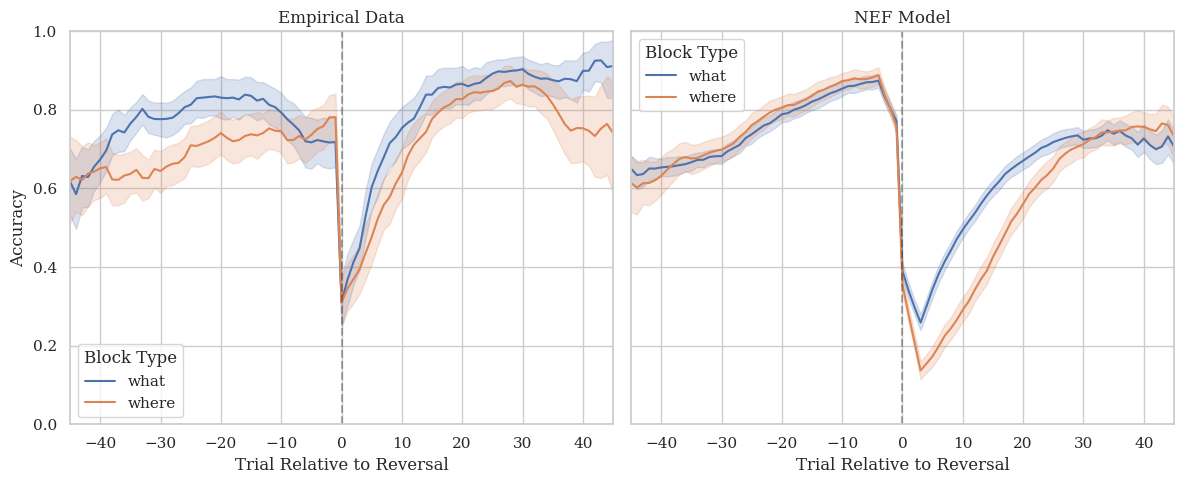

In [8]:
plot_performance(nef_data, window_size=7)

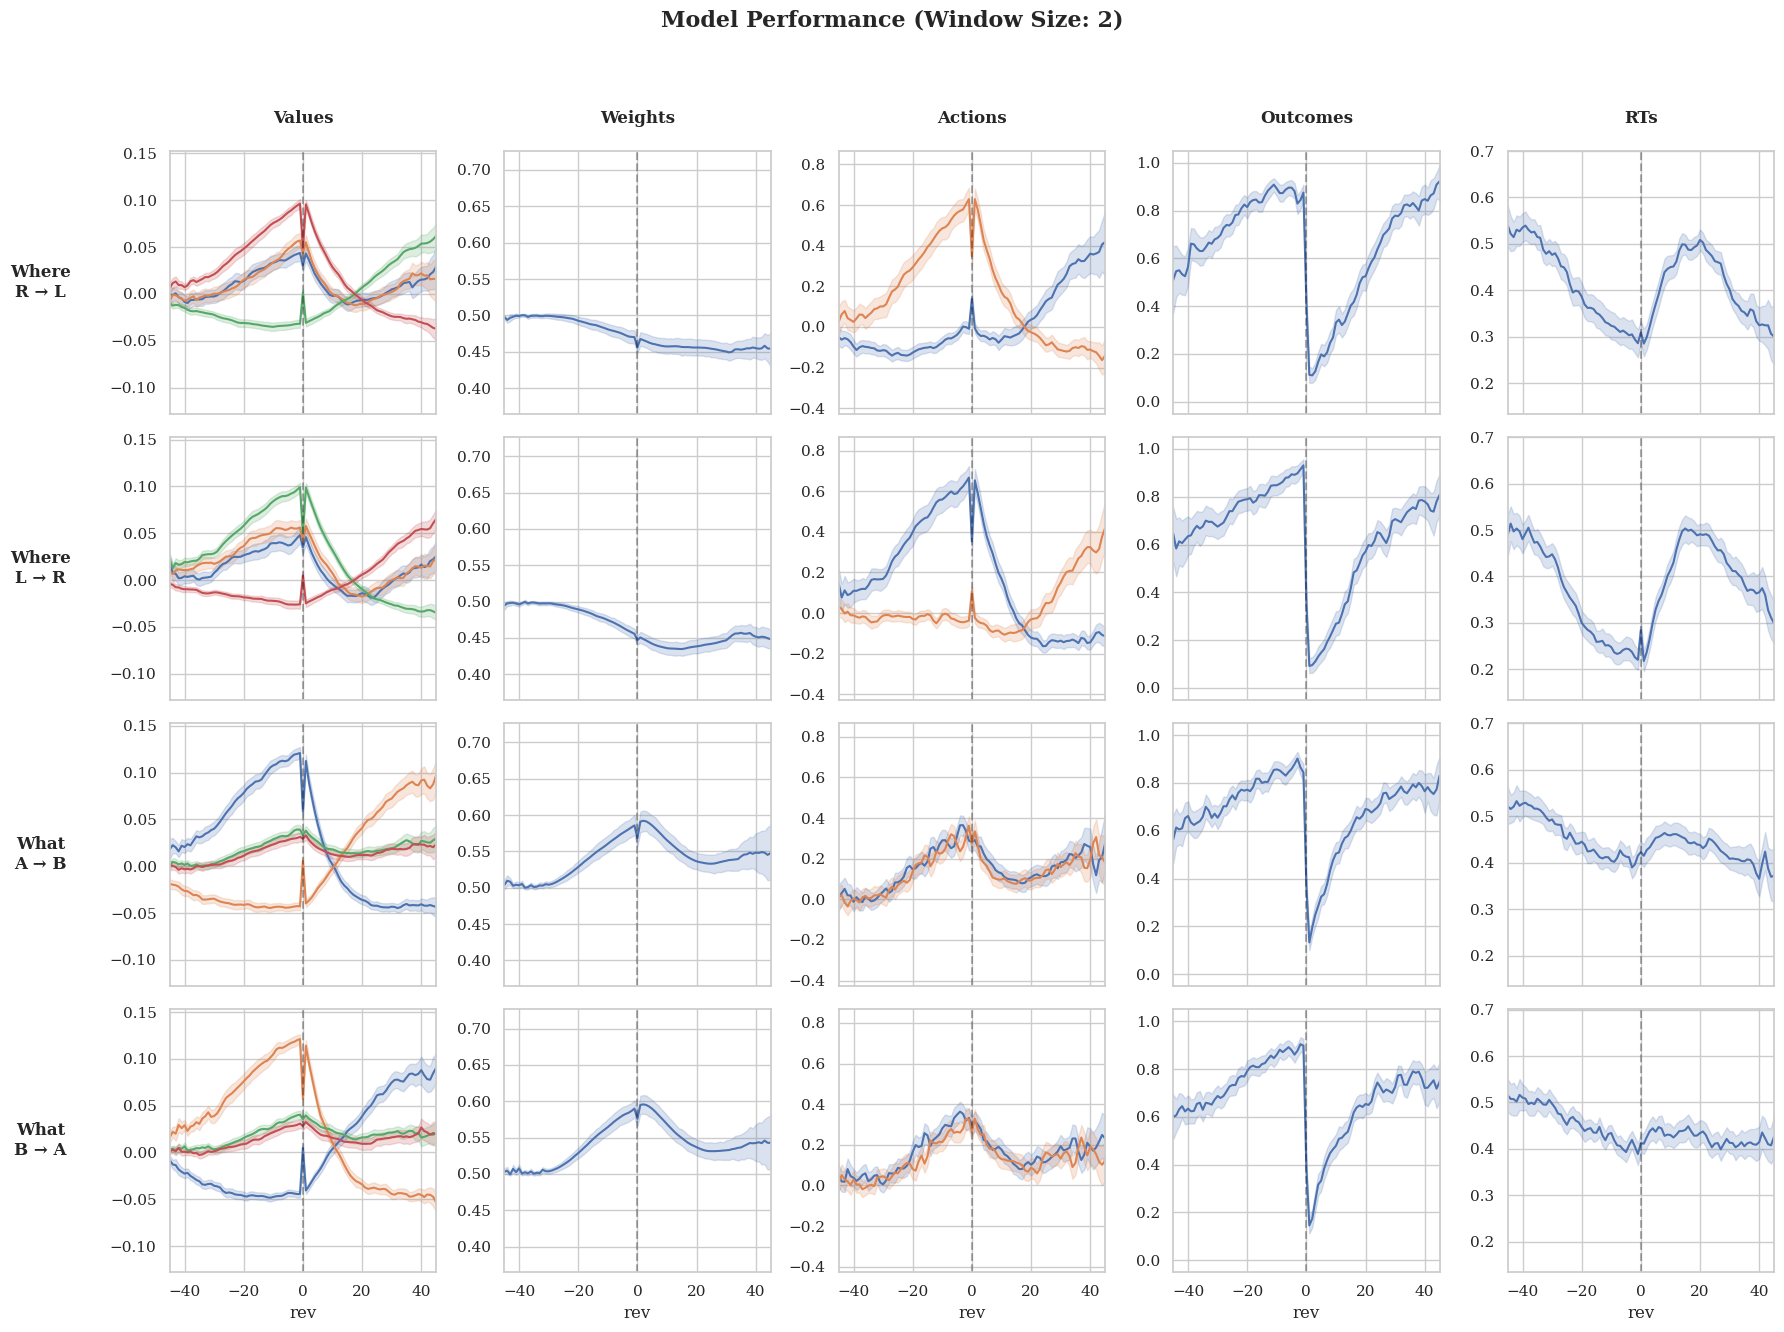

In [9]:
plot_values(nef_data, window_size=2)

# Ramping

In [10]:
def load_adjust_full(df):
    df['acc'] = df['acc'].replace(-1, 0)
    emp = pd.read_pickle("data/empirical2.pkl")
    block_mapping = emp[['block', 'block_type']].drop_duplicates().set_index('block')['block_type']
    df['block_type'] = df['block'].map(block_mapping)
    join_keys = ['monkey', 'session', 'block']
    df = df.merge(emp, on=join_keys, how='left')
    df['t_since_cue'] = df['time'] % 3.0 - 1.0
    df['da'] = np.abs(df['al'] - df['ar'])
    return df

In [12]:
nef_data_full = pd.read_pickle("data/nef/nef_data_full.pkl.xz")

In [ ]:
nef_data_full = adjust_full(nef_data_full)

In [11]:
def plot_ramp(df, var):
    df_what = df.query("block<=12 & time>=210")
    df_where = df.query("block>12 & time>=210")
    fig, ax = plt.subplots(figsize=(4,4))
    sns.lineplot(df_what, x='t_since_cue', y=var, ax=ax, color=palette[0], label='what')
    sns.lineplot(df_where, x='t_since_cue', y=var, ax=ax, color=palette[1], label='where')
    ax.legend()
    plt.tight_layout()
    plt.show()

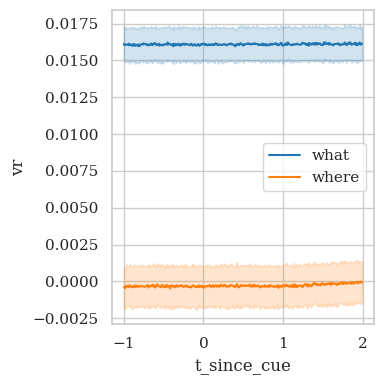

In [13]:
plot_ramp(nef_data_full, var='vr')

In [27]:
pd.read_pickle("data/empirical2.pkl").query("monkey=='V' & session==3 & block==6")

,block,block_type,trial,left,right,cor_loc,cor_let,clet,cloc,monkey_accuracy,reward,reversal_at_trial,monkey,session
5760,6,let_AB,1,A,B,left,A,A,left,1,1,34,V,3
5761,6,let_AB,2,B,A,right,A,A,right,1,1,34,V,3
5762,6,let_AB,3,A,B,left,A,A,left,1,0,34,V,3
5763,6,let_AB,4,B,A,right,A,A,right,1,1,34,V,3
5764,6,let_AB,5,A,B,left,A,A,left,1,1,34,V,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5835,6,let_AB,76,A,B,right,B,B,right,1,0,34,V,3
5836,6,let_AB,77,B,A,left,B,B,left,1,1,34,V,3
5837,6,let_AB,78,B,A,left,B,B,left,1,1,34,V,3
5838,6,let_AB,79,B,A,left,B,B,left,1,1,34,V,3
